In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

Refrences of information:

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/ <br>
https://www.digitalocean.com/community/tutorials/logistic-regression-with-scikit-learn <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
https://www.geeksforgeeks.org/python/make_pipeline-function-in-sklearn/ <br>
https://www.w3schools.com/python/python_ml_cross_validation.asp <br>
https://koshurai.medium.com/simplifying-machine-learning-workflows-with-scikit-learns-make-pipeline-19cb80ee3796 <br>
https://www.geeksforgeeks.org/python/make_pipeline-function-in-sklearn/ <br>
https://blog.alliedoffsets.com/mastering-hyperparameter-tuning-with-gridsearchcv-in-python-a-practical-guide <br>
https://dev.to/balapriya/cross-validation-and-hyperparameter-search-in-scikit-learn-a-complete-guide-5ed8 <br>
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea <br>

In [8]:
from pathlib import Path
import numpy as np

# ---------- Get paths to images and their labels ----------
def list_paths_and_labels(root):
    """_This function goes through all of the images, and saves their paths and labels in individual lists and returns them as 1-D arrays_

    Args:
        root (_string_): _The path to be taken to the folder that contains the folder of fake images (ai) or real images (not ai)_

    Returns:
        _two 1-D arrays: _two 1-D lists are returned, one of a list of paths to the .jpg image as string, and a list of labels of the .jpg image_
    """
    x, y = [], []
    for label, F_or_R in enumerate(["FAKE","REAL"]): 
        for p in (Path(root)/F_or_R).glob("*.jpg"):
            x.append(str(p)); y.append(label)
    return np.array(x, dtype=object), np.array(y)

x_train, y_train = list_paths_and_labels("train")
x_test,  y_test  = list_paths_and_labels("test")


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np

# ---------- Images changed to be preprocessed ----------
class ImageFeaturiser(BaseEstimator, TransformerMixin):
    """_Images are able to be transformed into grayscale, resized and flattened to a 1-D array_

    Args:
        BaseEstimator (_class_): _essential for make_pipeline class, it helps with hyperparameters_
        TransformerMixin (_class_): _essential for make_pipeline class, it helps with transforming data_
    """
    def __init__(self, img_size=(32, 32)):
        self.img_size = img_size

    def fit(self, X, y=None):
        return self

    def _process_one(self, path):
        img = imread(path)
        if img.ndim == 3:
            img = rgb2gray(img)
        img = resize(img, self.img_size, anti_aliasing=True)
        return img.flatten().astype("float32")

    def transform(self, X):
        return np.vstack([self._process_one(p) for p in X])


In [10]:
# ---------- Logistic Regression and 5 Fold Cross Validation ----------
"""_ A machine learning pipeline is made using logistic regression, a 5 fold cross validation is set up along with the hyperparameters_
"""
pipe = make_pipeline(
    ImageFeaturiser(img_size=(32, 32)),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
  "logisticregression__solver": ["lbfgs"],  # what algorithm is best to use to train based on how it trains
  "logisticregression__penalty": ["l2"], # prevents overfitting, makes sure to filter out extreme values
  "logisticregression__C": [0.01, 0.1, 1, 10, 100], # how much the penalty is enforced and tries different values to see which works best
}

In [11]:
# ---------- The best parameters are found and the model is trained ----------
"""_The logistic regression model is trained using the hyperparameters and the cross validation to find the best hyperparameters to use for the training model _
"""
search = GridSearchCV(pipe, param_grid, cv= folds, scoring="f1", n_jobs=1, pre_dispatch=1, refit=True, error_score="raise",verbose=1)

# The search for the best hyperparameters has started, and then will be saved
search.fit(x_train, y_train)
best_pipe = search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [12]:
# ---------- Evaluation and Prediction ----------
"""_The model is trained with the best hyperparameters and then an evaluation of the logistic regression model and its accuracy is shown_
"""
y_pred = best_pipe.predict(x_test)
print("Best params:", search.best_params_)
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=["FAKE","REAL"])) # it shows the accuracy of the AI's predictions, and the overall statistics of correct predictions etc.

Best params: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Classification report:
               precision    recall  f1-score   support

        FAKE       0.65      0.67      0.66     10000
        REAL       0.66      0.64      0.65     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



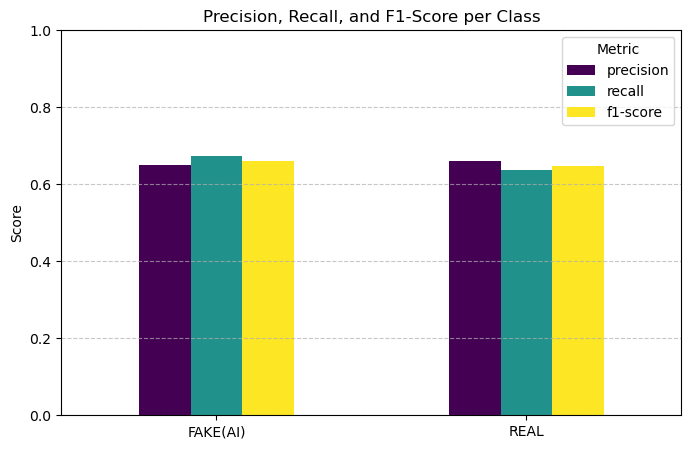

In [ ]:
# ---- bar chart of precision/recall/f1 ----
"""
A bar chart is made representing the classification report in a more visual manner, showing the accuracy of each class - FAKE and REAL
"""
report = classification_report(y_test, y_pred, output_dict=True)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# The classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True, target_names=["FAKE(AI)", "REAL"])

# Convert the classification report to a DataFrame
df = pd.DataFrame(report).transpose()
df_classes = df.loc[["FAKE(AI)", "REAL"], ["precision", "recall", "f1-score"]]

# Plot bar chart
ax = df_classes.plot(kind="bar", figsize=(8,5), colormap="viridis")
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metric")
plt.show()


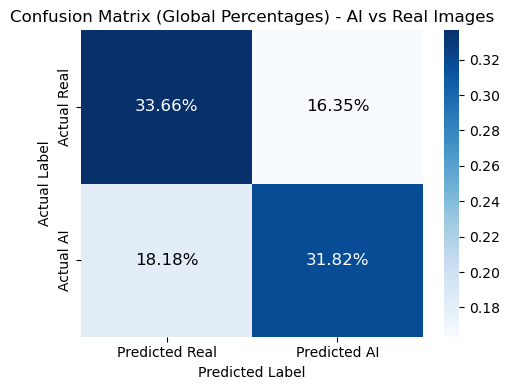

In [39]:
# ---- confusion matrix of correct and incorrect predictions ----
"""
This visually displays the correct predictions versus the incorrect predictions
"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix is found and the percentage is found and used
cm = confusion_matrix(y_test, y_pred).astype(float)
pct = cm / cm.sum()  
plt.figure(figsize=(5,4))
ax = sns.heatmap(pct,  annot=False, fmt='.2%', cmap="Blues", xticklabels=["Predicted Real","Predicted AI"], yticklabels=["Actual Real","Actual AI"])

# the threshold for light and dark values are found and 
threshold = 0.5 * (pct.max() + pct.min())
for (i, j), val in np.ndenumerate(pct):
    colour = "white" if val > threshold else "black" # the colour is set up based on the background (aka the percentage valued against the threshold)
    ax.text(j+0.5, i+0.5, f"{val:.2%}", ha="center", va="center", color=colour, fontsize=12) # the val is the percentage and that is put in the centre of the square

plt.title("Confusion Matrix (Global Percentages) - AI vs Real Images")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


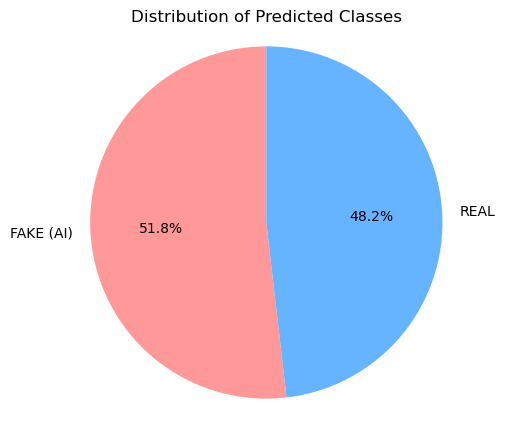

In [44]:
# ---- predicted class pie chart ----
"""
This displays the overall results of the logistic regression model's predictions
"""
import matplotlib.pyplot as plt
import numpy as np

# Count predicted labels
unique, counts = np.unique(y_pred, return_counts=True)

# Labels are made
labels_map = {0: "FAKE (AI)", 1: "REAL"}
labels = [labels_map.get(u, f"Class {u}") for u in unique] # gets the label of each unique class

# Pie chart is made
plt.figure(figsize=(5,5))
plt.pie(
    counts, # the predictions of each unique class
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#ff9999", "#66b3ff"]
)
plt.title("Distribution of Predicted Classes")
plt.axis("equal")  # make it a circle
plt.show()